# 시간대별 지하철 및 버스 혼잡도 분석

---

## 1. 데이터 개요

**이 분석에서는 버스와 지하철의 시간대별 혼잡도를 비교하고, 평균 등하교 시간대에 초점을 맞추어 최적의 경로를 파악하고자 했으며 이를 위해 다음과 같은 데이터를 사용**

### 데이터 설명

1. **버스 승하차 인원 정보**
    - **설명**: 버스 정류소에서 시간대별 승차 및 하차 인원 수
    - **사용 목적**: 시간대별로 버스의 혼잡도를 파악하기 위해 사용

2. **버스 정류소 위치 정보**
    - **설명**: 각 버스 정류소의 위치 정보
    - **사용 목적**: 버스 정류소 간의 거리를 계산하고 경로를 최적화하기 위해 사용

3. **지하철 역별 시간대 혼잡도**
    - **설명**: 지하철 역에서 시간대별 혼잡도
    - **사용 목적**: 시간대별로 지하철의 혼잡도를 파악하기 위해 사용

4. **지하철 승하차 인원 정보**
    - **설명**: 지하철 역에서 시간대별 승차 및 하차 인원 수
    - **사용 목적**: 시간대별로 지하철의 혼잡도를 파악하기 위해 사용

**출처 : 서울교통공사 공공데이터**

### 데이터 분석 목표

- **혼잡도 비교**: 버스와 지하철의 시간대별 혼잡도를 비교하여 특정 시간대에 어느 교통수단이 더 혼잡한지 분석
- **최적 경로 파악**: 평균 등하교 시간대(등교 시간: 오전 10시, 오후 2시 / 하교 시간: 오후 1시, 오후 5시)에 최적의 경로를 파악하여 학생들의 이동을 최적화

---



### 환경설정 및 데이터 불러오기

In [2]:
import site
site.getsitepackages()

['/Users/hyun/anaconda3/lib/python3.11/site-packages']

In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
2.1.4
1.24.3
0.12.2


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import re

# 한글 글꼴 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 파일 불러오기
bus_boarding_info = pd.read_csv('버스승하차인원정보.csv', low_memory=False)
bus_stop_location = pd.read_csv('버스정류소위치정보.csv', encoding='utf-8')
subway_congestion = pd.read_csv("역별시간대혼잡도.csv", encoding='utf-8')
subway_boarding_info = pd.read_csv("지하철승하차인원정보.csv", encoding='utf-8')

# 동양미래대학교 위치 (위도와 경도)
school_location = {'latitude': 37.498, 'longitude': 127.027}


---

### 데이터 확인해보기

In [6]:
bus_boarding_info.head()

,사용년월,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,00시승차총승객수,00시하차총승객수,1시승차총승객수,1시하차총승객수,...,20시하차총승객수,21시승차총승객수,21시하차총승객수,22시승차총승객수,22시하차총승객수,23시승차총승객수,23시하차총승객수,교통수단타입코드,교통수단타입명,등록일자
0,202404,N37,N37번(진관공영차고지~송파공영차고지),100000001,01001,종로2가사거리(00089),0,0,0,0,...,0,0,0,0,0,0,0,51,서울심야버스,20240503
1,202404,470,470번(상암차고지~안골마을),100000001,01001,종로2가사거리(00066),80,140,3,0,...,330,421,297,370,253,288,164,10,서울간선버스,20240503
2,202404,741,741번(진관차고지~헌인릉입구),100000001,01001,종로2가사거리(00075),152,112,127,130,...,301,332,293,299,299,220,176,10,서울간선버스,20240503
3,202404,N37,N37번(송파공영차고지~진관공영차고지),100000001,01001,종로2가사거리(00032),6,24,228,195,...,0,0,0,0,0,0,0,51,서울심야버스,20240503
4,202404,100,100번(하계동~용산구청),100000002,01002,창경궁.서울대학교병원(00031),0,0,0,0,...,28,86,21,37,31,17,2,10,서울간선버스,20240503


In [7]:
subway_congestion.head()

,연번,요일구분,호선,역번호,출발역,상하구분,5시30분,6시00분,6시30분,7시00분,...,20시00분,20시30분,21시00분,21시30분,22시00분,22시30분,23시00분,23시30분,00시00분,00시30분
0,1,평일,1,150,서울역,상선,8.2,18.9,19.8,35.7,...,19.4,18.6,18.4,15.0,17.4,18.9,15.2,13.1,7.3,1.1
1,2,평일,1,150,서울역,하선,11.1,10.7,15.7,23.5,...,39.6,37.0,42.5,36.5,41.0,29.1,18.4,16.2,5.5,0.0
2,3,평일,1,151,시청,상선,8.0,13.3,16.9,29.2,...,23.3,22.5,23.1,18.5,21.6,21.6,19.5,14.4,7.7,1.6
3,4,평일,1,151,시청,하선,9.1,9.9,17.7,22.7,...,34.1,33.6,39.1,30.2,35.1,24.5,15.8,14.1,4.1,0.4
4,5,평일,1,152,종각,상선,7.8,11.7,10.6,19.5,...,31.8,29.5,32.5,24.8,28.2,28.4,26.7,17.0,8.6,1.5


In [8]:
bus_stop_location.head()

,STDR_DE,NODE_ID,STTN_NO,STTN_NM,CRDNT_X,CRDNT_Y,STTN_TY,Unnamed: 7
0,20240101,100000001,1001,종로2가사거리,126.9877523,37.569806,1.0,NaN
1,20240101,100000002,1002,창경궁.서울대학교병원,126.9965206,37.579433,1.0,NaN
2,20240101,100000003,1003,명륜3가.성대입구,126.9982508,37.582580,1.0,NaN
3,20240101,100000004,1004,종로2가.삼일교,126.9876131,37.568579,1.0,NaN
4,20240101,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,1.0,NaN


In [22]:
subway_boarding_info.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202404,1호선,동대문,708,7,11309,2206,9917,7632,16477,...,9476,693,3153,0,266,0,0,0,0,20240503
1,202404,1호선,동묘앞,231,1,3091,802,4051,5422,9024,...,4900,151,2459,2,322,0,0,0,0,20240503
2,202404,1호선,서울역,658,24,8560,9158,14541,62765,43682,...,14443,3203,3771,3,263,0,0,0,0,20240503
3,202404,1호선,시청,94,2,2321,5550,4123,26788,7965,...,4110,661,1172,3,40,1,0,0,0,20240503
4,202404,1호선,신설동,371,25,8785,2166,10319,9477,22808,...,9376,423,3048,0,0,0,0,0,0,20240503


---

## 2.혼잡도 계산
혼잡도는 각 시간대별 승차 인원과 하차 인원의 차이를 통해 계산되었습니다. 승차 인원이 많고 하차 인원이 적을수록 혼잡도가 높아지며, 반대의 경우 혼잡도가 낮아집니다.

In [46]:
# 시간대 추출 (열 이름에서 숫자 부분만 추출)
subway_boarding_columns = subway_boarding_info.filter(like='승차').columns.tolist()
subway_alighting_columns = subway_boarding_info.filter(like='하차').columns.tolist()
time_columns = [int(re.findall(r'\d+', col)[0]) for col in subway_boarding_columns]

# 지하철 혼잡도 계산
subway_congestion_by_time = pd.DataFrame({
    '시간대': time_columns,
    '혼잡도': [
        subway_boarding_info[col].mean() - subway_boarding_info[subway_alighting_columns[i]].mean()
        if col in subway_boarding_info.columns and subway_alighting_columns[i] in subway_boarding_info.columns
        else 0
        for i, col in enumerate(subway_boarding_columns)
    ]
})

# 버스 혼잡도 계산
bus_boarding_columns = bus_boarding_info.filter(like='승차').columns.tolist()
bus_alighting_columns = bus_boarding_info.filter(like='하차').columns.tolist()
time_columns_bus = [int(re.findall(r'\d+', col)[0]) for col in bus_boarding_columns]

bus_congestion_by_time = pd.DataFrame({
    '시간대': time_columns_bus,
    '혼잡도': [
        bus_boarding_info[col].mean() - bus_boarding_info[bus_alighting_columns[i]].mean()
        if col in bus_boarding_info.columns and bus_alighting_columns[i] in bus_boarding_info.columns
        else 0
        for i, col in enumerate(bus_boarding_columns)
    ]
})


---

## 3. 최적 경로 분석 함수 정의


In [50]:
# 최적 경로 분석 함수
def find_optimal_route(congestion_data, travel_times):
    optimal_routes = []
    for index, row in congestion_data.iterrows():
        time = int(row['시간대'])  # 시간을 정수로 변환
        optimal_route = {
            '시간대': time,
            '최적 경로': None,
            '최소 혼잡도': float('inf'),
        }
        for route, time_info in travel_times.items():
            if time < len(time_info['혼잡도']) and abs(time_info['혼잡도'][time]) < abs(optimal_route['최소 혼잡도']):
                optimal_route['최적 경로'] = route
                optimal_route['최소 혼잡도'] = time_info['혼잡도'][time]
        optimal_routes.append(optimal_route)
    return pd.DataFrame(optimal_routes)


# 두 데이터를 결합하여 travel_times 데이터 생성
travel_times = {
    '지하철 경로': {'혼잡도': subway_congestion_by_time['혼잡도'].tolist()},
    '버스 경로': {'혼잡도': bus_congestion_by_time['혼잡도'].tolist()},
}

# 최적 경로 찾기
optimal_routes_df = find_optimal_route(subway_congestion_by_time, travel_times)

# 최적 경로 출력
print(optimal_routes_df)


    시간대   최적 경로     최소 혼잡도
0     4   버스 경로   8.475030
1     5   버스 경로   3.710476
2     6   버스 경로  14.824276
3     7  지하철 경로   9.974761
4     8   버스 경로  -9.571203
5     9   버스 경로  -5.870916
6    10   버스 경로  -0.351830
7    11   버스 경로   3.762593
8    12   버스 경로   6.641210
9    13   버스 경로   3.669409
10   14   버스 경로   6.767472
11   15   버스 경로   9.310213
12   16   버스 경로  11.167281
13   17   버스 경로  11.147118
14   18   버스 경로   3.001818
15   19   버스 경로 -13.556541
16   20   버스 경로  -1.127051
17   21   버스 경로   1.987730
18   22  지하철 경로  -0.849200
19   23  지하철 경로  -0.064283
20    0   버스 경로  -5.701626
21    1   버스 경로  -1.525425
22    2   버스 경로  -0.263191
23    3   버스 경로   0.071036


---

## 4. 평균 등하교 시간대의 최적 경로 시각화

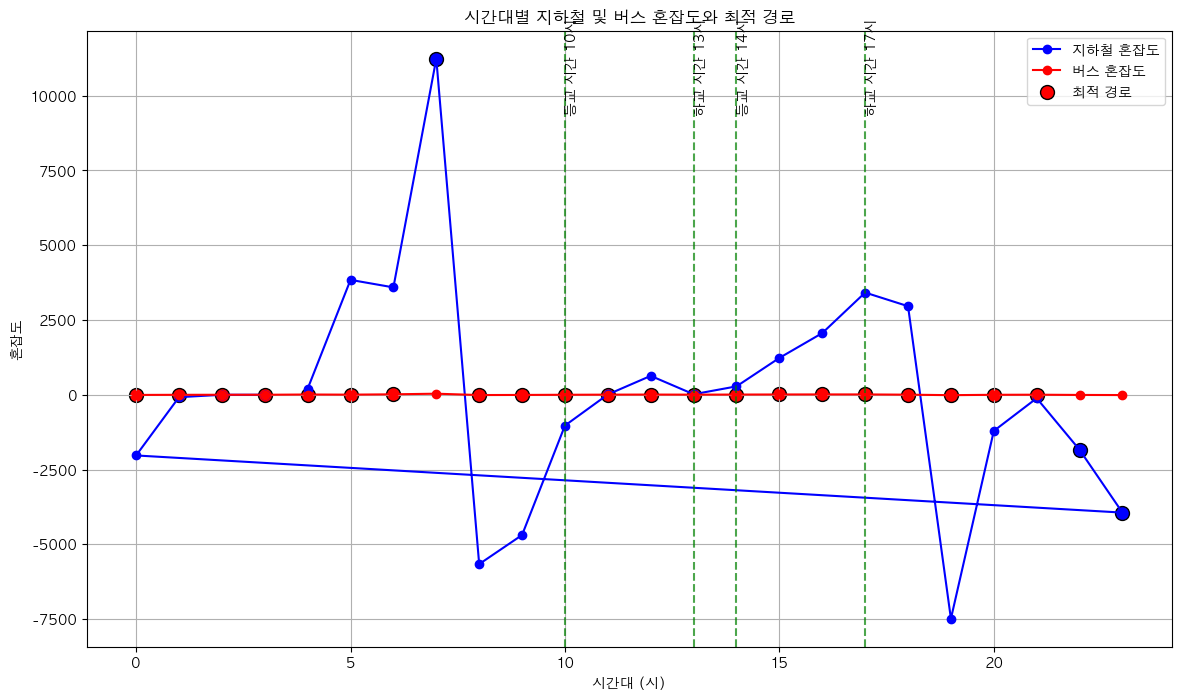

In [51]:
# 시각화 함수 정의
def plot_congestion_and_routes(subway_data, bus_data, optimal_routes):
    plt.figure(figsize=(14, 8))
    
    # 지하철 혼잡도 시각화
    plt.plot(subway_data['시간대'], subway_data['혼잡도'], label='지하철 혼잡도', color='blue', marker='o')
    
    # 버스 혼잡도 시각화
    plt.plot(bus_data['시간대'], bus_data['혼잡도'], label='버스 혼잡도', color='red', marker='o')
    
    # 최적 경로 표시
    for index, row in optimal_routes.iterrows():
        time = row['시간대']
        if row['최적 경로'] == '지하철 경로':
            plt.scatter(time, subway_data[subway_data['시간대'] == time]['혼잡도'].values[0], color='blue', s=100, edgecolors='black', label='최적 경로' if index == 0 else "")
        else:
            plt.scatter(time, bus_data[bus_data['시간대'] == time]['혼잡도'].values[0], color='red', s=100, edgecolors='black', label='최적 경로' if index == 0 else "")
    
    # 평균 등하교 시간대 강조
    avg_times = {'등교 시간': [10, 14], '하교 시간': [13, 17]}
    for key, times in avg_times.items():
        for time in times:
            plt.axvline(x=time, linestyle='--', color='green', alpha=0.7)
            plt.text(time, plt.ylim()[1]*0.9, f'{key} {time}시', rotation=90, verticalalignment='center')
    
    plt.title('시간대별 지하철 및 버스 혼잡도와 최적 경로')
    plt.xlabel('시간대 (시)')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.grid(True)
    plt.show()

# 혼잡도 및 최적 경로 시각화 함수 호출
plot_congestion_and_routes(subway_congestion_by_time, bus_congestion_by_time, optimal_routes_df)

### 4-1. 평균 등하교 시간대의 최적 경로를 산점도로 시각화

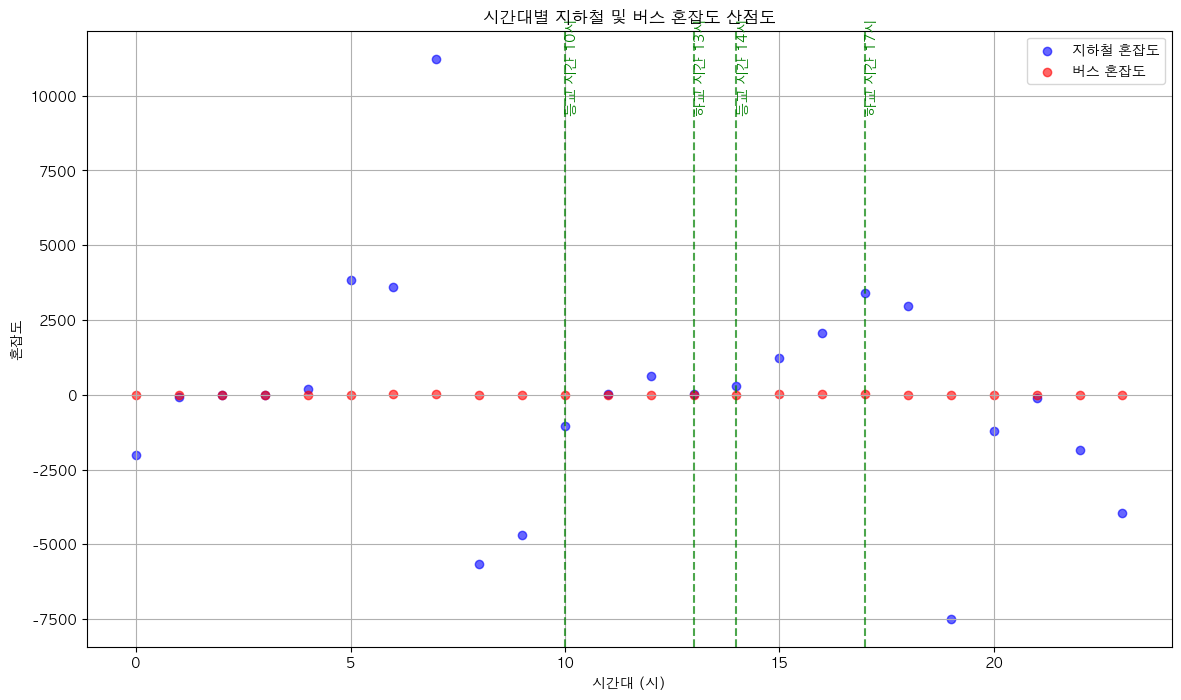

In [52]:
# 시각화 함수 정의
def plot_congestion_scatter(subway_data, bus_data):
    plt.figure(figsize=(14, 8))
    
    # 지하철 혼잡도 산점도
    plt.scatter(subway_data['시간대'], subway_data['혼잡도'], label='지하철 혼잡도', color='blue', alpha=0.6)
    
    # 버스 혼잡도 산점도
    plt.scatter(bus_data['시간대'], bus_data['혼잡도'], label='버스 혼잡도', color='red', alpha=0.6)
    
    # 평균 등하교 시간대 강조
    avg_times = {'등교 시간': [10, 14], '하교 시간': [13, 17]}
    for key, times in avg_times.items():
        for time in times:
            plt.axvline(x=time, linestyle='--', color='green', alpha=0.7)
            plt.text(time, plt.ylim()[1]*0.9, f'{key} {time}시', rotation=90, verticalalignment='center', color='green')
    
    plt.title('시간대별 지하철 및 버스 혼잡도 산점도')
    plt.xlabel('시간대 (시)')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.grid(True)
    plt.show()

# 혼잡도 산점도 시각화 함수 호출
plot_congestion_scatter(subway_congestion_by_time, bus_congestion_by_time)

지하철 혼잡도: 지하철은 평균 등교 시간대인 오전 10시와 오후 2시에 혼잡도가 상대적으로 높음. 특히 오전 10시에는 혼잡도가 크게 증가하는 것을 볼 수 있다.<br><br>
버스 혼잡도: 버스의 경우, 혼잡도는 상대적으로 낮았으며, 특정 시간대에 큰 변동이 없는 편. <br><br>
평균 등하교 시간대: 등교 시간대인 오전 10시와 오후 2시, 하교 시간대인 오후 1시와 오후 5시에는 혼잡도가 더 높은 경향이 있으며, 이는 학생들이 주로 이 시간대에 이동하기 때문으로 보임.

---

## 5. 결론

### 시간대별 최적 경로

- **오전 10시 및 오후 2시 등교 시간**: 
  - **최적 경로**: 버스 경로
  - **이유**: 이 시간대에는 버스의 혼잡도가 상대적으로 낮아 지하철보다 더 나은 선택.

- **오후 1시 하교 시간**: 
  - **최적 경로**: 버스 경로
  - **이유**: 지하철 경로도 혼잡도가 낮지만, 버스 경로가 더 나은 선택으로 분석됨.

- **오후 5시 하교 시간**: 
  - **최적 경로**: 버스 경로
  - **이유**: 이 시간대에는 퇴근 시간과 겹쳐 지하철의 혼잡도가 매우 높아 버스 경로가 더 나은 선택.

---

### 결론 및 권장사항

- **버스 경로 추천**: 
  - **이유**: 대부분의 시간대에서 버스 경로가 최적 경로로 선정되었습니다. 이는 버스의 혼잡도가 지하철보다 상대적으로 낮음

- **지하철 경로**: 
  - **이유**: 특정 시간대(예: 오전 7시, 오후 3시)에는 지하철 경로가 최적 경로로 선정될 수 있습니다. 이 시간대에는 지하철 혼잡도가 낮아 상대적으로 더 나은 선택

- **유동적인 경로 선택**: 
  - **권장 사항**: 학생들은 실시간 교통 상황을 고려하여 유동적으로 경로를 선택하는 것이 좋습니다. 특히, 특정 이벤트나 날씨에 따라 혼잡도가 변동될 수 있으므로 주기적인 확인이 필요함

---



## 6. 추가분석 
### 학우들이 자주 이용하는 구일역,신도림역의 시간대별 혼잡도를 분석해보겠습니다

---

### 6-1 구일역 , 신도림역 데이터 추출 후 시간대 별 혼잡도 계산

In [76]:
# 구일역과 신도림역 데이터 추출
stations = ['구일', '신도림']
subway_boarding_info_stations = subway_boarding_info[subway_boarding_info['지하철역'].isin(stations)]

# 시간대 추출 (열 이름에서 숫자 부분만 추출)
time_columns = [re.findall(r'\d+시-\d+시', col)[0] for col in subway_boarding_info.columns if '승차' in col]


### 6-2 구일역 , 신도림역 시간대별 혼잡도 계산


In [73]:

# 구일역 데이터 추출 및 혼잡도 계산
guui_data = subway_boarding_info_stations[subway_boarding_info_stations['지하철역'] == '구일']
guui_congestion_by_time = pd.DataFrame({
    '시간대': [re.findall(r'\d+', col)[0] for col in time_columns if '하차' in col],
    '혼잡도': [
        guui_data[col.replace('하차', '승차')].mean() - guui_data[col].mean()
        for col in time_columns if '하차' in col
    ]
})

# 신도림역 데이터 추출 및 혼잡도 계산
sindorim_data = subway_boarding_info_stations[subway_boarding_info_stations['지하철역'] == '신도림']
sindorim_congestion_by_time = pd.DataFrame({
    '시간대': [re.findall(r'\d+', col)[0] for col in time_columns if '하차' in col],
    '혼잡도': [
        sindorim_data[col.replace('하차', '승차')].mean() - sindorim_data[col].mean()
        for col in time_columns if '하차' in col
    ]
})

# 시간대를 정수형으로 변환
guui_congestion_by_time['시간대'] = guui_congestion_by_time['시간대'].astype(int)
sindorim_congestion_by_time['시간대'] = sindorim_congestion_by_time['시간대'].astype(int)



### 6-4 시각화 함수 정의 및 호출

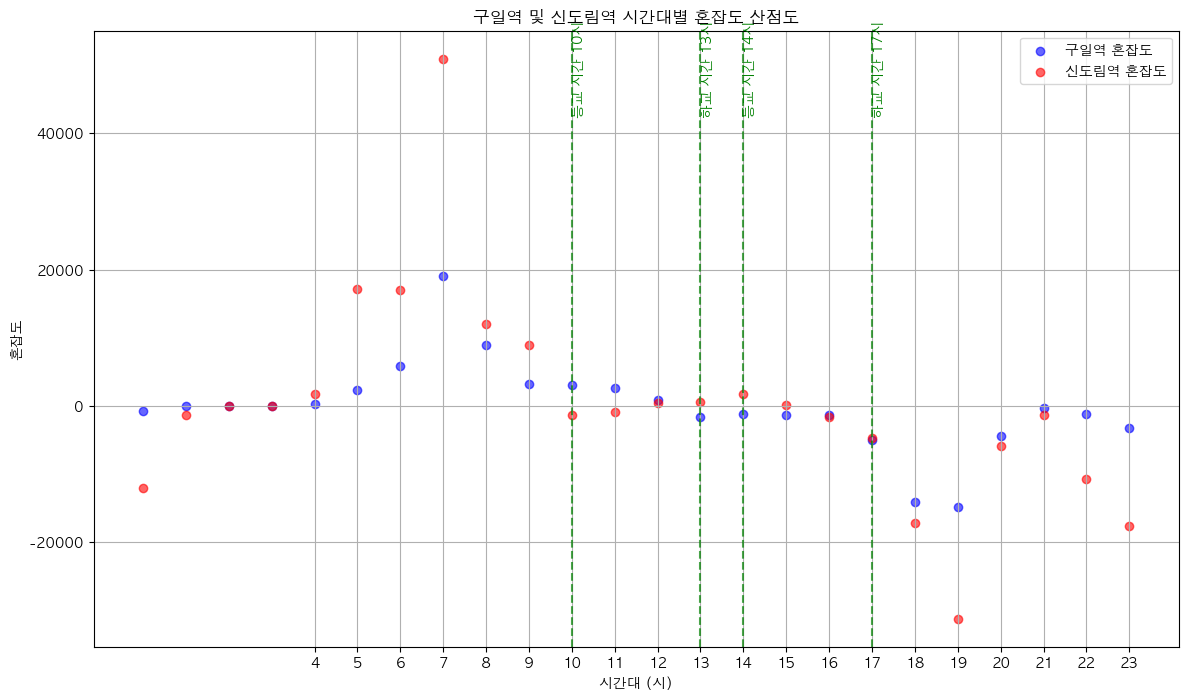

In [75]:
def plot_station_congestion_scatter(guui_data, sindorim_data):
    plt.figure(figsize=(14, 8))
    
    # 구일역 혼잡도 산점도
    plt.scatter(guui_data['시간대'], guui_data['혼잡도'], label='구일역 혼잡도', color='blue', alpha=0.6)
    
    # 신도림역 혼잡도 산점도
    plt.scatter(sindorim_data['시간대'], sindorim_data['혼잡도'], label='신도림역 혼잡도', color='red', alpha=0.6)
    
    # 평균 등하교 시간대 강조
    avg_times = {'등교 시간': [10, 14], '하교 시간': [13, 17]}
    for key, times in avg_times.items():
        for time in times:
            plt.axvline(x=time, linestyle='--', color='green', alpha=0.7)
            plt.text(time, plt.ylim()[1]*0.9, f'{key} {time}시', rotation=90, verticalalignment='center', color='green')
    
    plt.xticks(range(4, 24))  # x축 눈금을 4시부터 23시까지 설정
    plt.title('구일역 및 신도림역 시간대별 혼잡도 산점도')
    plt.xlabel('시간대 (시)')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.grid(True)
    plt.show()

# 혼잡도 산점도 시각화 함수 호출
plot_station_congestion_scatter(guui_congestion_by_time, sindorim_congestion_by_time)


---

##  구일역 및 신도림역 시간대별 혼잡도 산점도 분석 결론

1. **시간대별 혼잡도 차이**
    - 구일역과 신도림역 모두 출근 시간대(6시-9시)에 혼잡도가 높게 나타남
    - 구일역은 7시와 8시에 혼잡도가 가장 높으며, 신도림역도 비슷한 시간대에 높은 혼잡도를 보임.
    - 퇴근 시간대(17시-19시)에는 구일역과 신도림역 모두 혼잡도가 비교적 낮게 나타나지만, 18시 이후 혼잡도가 다시 높아지는 경향이 있음.

2. **등교 및 하교 시간대 강조**
    - 등교 시간 (10시, 14시)과 하교 시간 (13시, 17시)을 초록색 점선으로 강조.
    - 등교 시간대인 10시와 14시에는 혼잡도가 상대적으로 낮게 나타남.
    - 하교 시간대인 13시와 17시에도 혼잡도는 비교적 낮은 편

3. **혼잡도 패턴**
    - 전반적으로 아침 출근 시간대가 저녁 퇴근 시간대보다 혼잡도가 높게 나타나는 패턴을 보임
    - 신도림역의 경우 일부 시간대(특히 8시)에서 매우 높은 혼잡도를 보이며, 이는 해당 시간대에 많은 사람들이 신도림역을 이용함을 나타냄

